## Introduction

@[DUY NGUYEN](https://www.linkedin.com/in/dnguyenngoc/)

This notebook is related to the article being posted here [Distributed ML model with Pandas UDFs](https://viblo.asia/posts/maGK7rWe5j2)


In [2]:
import os
import glob
import pandas as pd
import random
from pyspark.sql import SparkSession
print(os.getcwd())
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, udf
from pyspark.sql.types import ArrayType, FloatType, StringType
import PIL
import time

/usr/local/share_storages/lab


In [4]:
ss  = SparkSession.builder.master('spark://spark-master:7077') \
                  .appName("test") \
                  .config("spark.executor.memory", "2g") \
                  .config("spark.driver.memory", "2g") \
                  .config("spark.executor.cores", "2") \
                  .config("spark.driver.cores", "2") \
                  .getOrCreate()
sc = ss.sparkContext
sc

<SparkContext master=spark://spark-master:7077 appName=test>

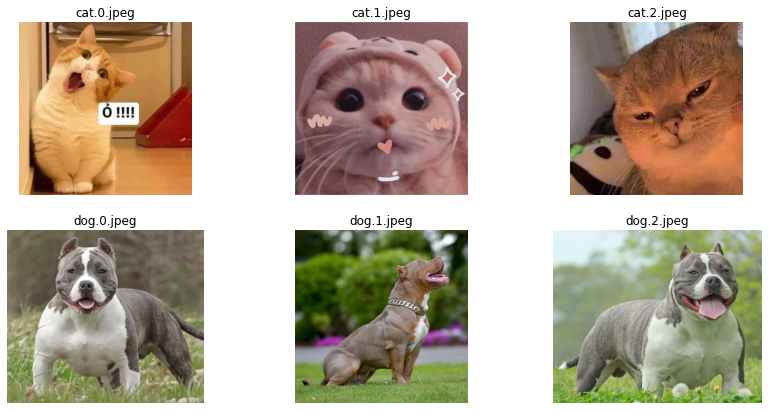

In [5]:
paths = glob.glob('/usr/local/share_storages/data/image/dog-cat/*.jpeg')
rows = 2
plt.figure(figsize=(14,7))
for num, x in enumerate(paths):
    image = PIL.Image.open(x)
    plt.subplot(rows,3, num+1)
    plt.title(x.split('/')[-1])
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [8]:
X1 = [100, 500, 1000, 1500, 2000, 2500, 3000]

random_path = [random.choice(paths) for i in range(3000)]
df = pd.DataFrame(random_path, columns=['path'])
df['label'] =df['path'].apply(lambda x: x.split("/")[-1].split(".")[0]
                             )
pdf = [df.iloc[: x] for x in X1[:-2]]
# pdf = [df.iloc[: x] for x in X1]
sdf = [ss.createDataFrame(df.iloc[: x]) for x in X1]

print(pdf[0].iloc[: 3])
sdf[0].show(3)

                                                path label
0  /usr/local/share_storages/data/image/dog-cat/d...   dog
1  /usr/local/share_storages/data/image/dog-cat/c...   cat
2  /usr/local/share_storages/data/image/dog-cat/d...   dog


+--------------------+-----+
|                path|label|
+--------------------+-----+
|/usr/local/share_...|  dog|
|/usr/local/share_...|  cat|
|/usr/local/share_...|  dog|
+--------------------+-----+
only showing top 3 rows



In [18]:
IMAGE_SIZE = 192 # (image input 192x192)
BATCH_SIZE = 2

# Preprocess an image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0  # normalize to [0,1] range
    return image

# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [11]:
X_p = []
X_d = []

def process_batch_python(all_paths):
    
    start_time = time.perf_counter()
    
    data_lenght = len(all_paths)
    model = keras.models.load_model("/usr/local/share_storages/data/model/dog_cat.h5")
    
    preprocessed_imgage = np.array([load_and_preprocess_image(item) for item in all_paths])
    
    predictions = model.predict(preprocessed_imgage, batch_size=BATCH_SIZE)
    predicted_labels = [{"class": "Cat", "score": x[0]} if x[0] >= 0.5 else {"class": "Dog", "score": x[0]} for x in predictions]
    
    end_time = time.perf_counter()
    
    return predicted_labels, end_time - start_time

for x in X1:
    pred, count_time = process_batch_python(df.iloc[:x]['path'])
    X_p.append(count_time)
    X_d.append(pred)
    print("Run with {} sample: {}s".format(x, count_time))

Run with 100 sample: 5.428100499997527s
Run with 500 sample: 15.379066599998623s
Run with 1000 sample: 33.48210130000007s
Run with 1500 sample: 44.866816599998856s
Run with 2000 sample: 58.65093120000165s
Run with 2500 sample: 72.51571390000026s
Run with 3000 sample: ngỏm.


In [11]:
X_udf = []
X_udf_d = []

def process_batch_udf(sdf):
    
    start_time = time.perf_counter()
    
    model = keras.models.load_model("/usr/local/share_storages/data/model/dog_cat.h5")
    bc_model_weights = sc.broadcast(model.get_weights())
    
    def cover_model():
        model.set_weights(bc_model_weights.value)
        return model
    
    model_fn = cover_model()
    
    @udf(StringType())
    def predict(img):
        processed_images = np.array([load_and_preprocess_image(img)])
        predictions = model_fn.predict(processed_images, batch_size=BATCH_SIZE)
        predicted_labels = ["Cat,{}".format(x[0]) if x[0] >= 0.5 else "Dog, {}".format(x[0])  for x in predictions]
        return predicted_labels[0]
    
    x= sdf.withColumn('v2', predict(sdf.path))
    x.show(1)
    
    end_time = time.perf_counter()
    return sdf, end_time - start_time      

for x in range(len(X1)):
    pred, count_time = process_batch_udf(sdf[x])
    X_udf.append(count_time)
    X_udf_d.append(pred)
    print("Run with {} sample: {}s".format(X1[x], count_time))

Run with 100 sample: 30.738601299999573s
Run with 500 sample: 39.60790839999754s
Run with 1000 sample: 56.82039040000018s
Run with 1500 sample: 64.21761259999766s
Run with 2000 sample: 69.66648029999851s
Run with 2500 sample: 89.24947419999808s
Run with 3000 sample: 91.57887720000144s


In [12]:
X_pudf = []
X_pudf_d = []

def process_batch_pandas_udf(sdf):
    start_time = time.perf_counter()
    model = keras.models.load_model("/usr/local/share_storages/data/model/dog_cat.h5")
    bc_model_weights = sc.broadcast(model.get_weights())

    def cover_model():
        model.set_weights(bc_model_weights.value)
        return model

    def keras_model_udf(model_fn):
        """
          Wraps an Keras model into a Pandas UDF that makes predictions.

          You might consider the following customizations for your own use case:
            - Tune DataLoader's batch_size and num_workers for better performance.
            - Use GPU for acceleration.
            - Change prediction types.
          """
        model = model_fn()
        def predict_batch(image_batch):
            data_lenght = len(image_batch)
            processed_images = np.array([load_and_preprocess_image(img) for img in image_batch])
            predictions = model.predict(processed_images, batch_size=BATCH_SIZE)
            predicted_labels = [{"class": "Cat", "score": x[0]} if x[0] >= 0.5 else {"class": "Dog", "score": x[0]} for x in predictions]
            return pd.DataFrame(predicted_labels)
        return_type = "class: string, score:float"
        return pandas_udf(return_type, PandasUDFType.SCALAR)(predict_batch)
    model_udf = keras_model_udf(cover_model)
    sdf.withColumn("prediction", model_udf(col("path"))).show(1)
    end_time = time.perf_counter()
    return sdf, end_time - start_time
    
for x in range(len(X1)):
    pred, count_time = process_batch_pandas_udf(sdf[x])
    X_pudf.append(count_time)
    X_pudf_d.append(pred)
    print("Run with {} sample: {}s".format(X1[x], count_time))

Run with 100 sample: 29.639200400000846s
Run with 500 sample: 33.74288650000017s
Run with 1000 sample: 38.36985210000057s
Run with 1500 sample: 50.09157480000067s
Run with 2000 sample: 49.84821749999901s
Run with 2500 sample: 46.89816769999743s
Run with 3000 sample: 47.90912639999806s


In [109]:
df_plot = pd.DataFrame({'X':X1, 'Y_p':X_p, 'Y_udf':X_udf, 'Y_pudf': X_pudf},)
df_plot

,X,Y_p,Y_udf,Y_pudf
0,100,5.428100,30.738601,29.639200
1,500,15.379067,39.607908,33.742887
2,1000,33.482101,56.820390,38.369852
3,1500,44.866817,64.217613,50.091575
4,2000,58.650931,69.666480,49.848217
5,2500,72.515714,89.249474,46.898168
6,3000,NaN,91.578877,47.909126


Text(0, 0.5, 'Seconds')

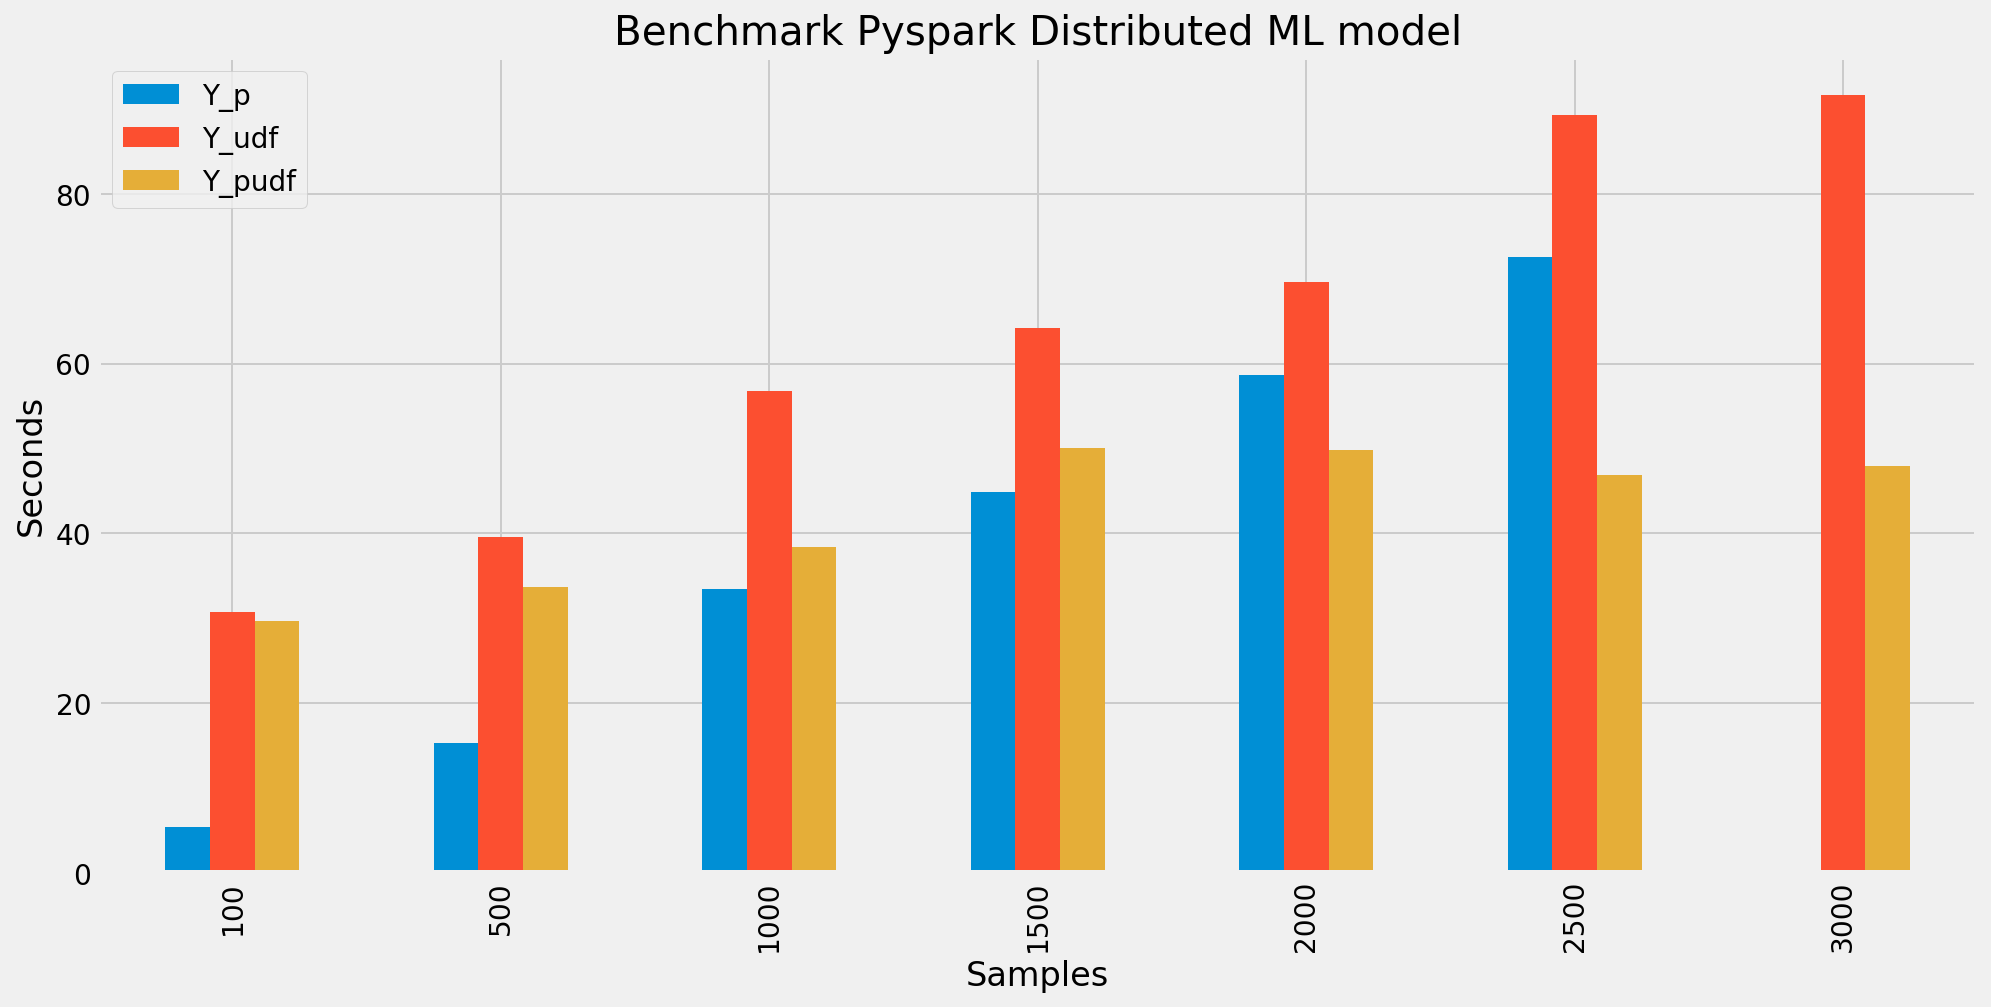

In [115]:
plt.rcParams["figure.figsize"] = [15, 7]
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('fivethirtyeight')
df_plot.plot(x="X", y=["Y_p", "Y_udf", "Y_pudf"], kind="bar")
plt.title("Benchmark Pyspark Distributed ML model")
plt.xlabel("Samples")
plt.ylabel("Seconds")